## Imports

In [1]:
# Import libraries
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import time
import random

## Setup Data

In [2]:
# Fetch the train/test data from the csv file
train_csv = 'Datasets/train_data.csv'
test_csv = 'Datasets/test_data.csv'

df_train = pd.read_csv(train_csv, index_col = 'Date')
df_test = pd.read_csv(test_csv, index_col = 'Date')

print('Successfully fetched train and test datasets')

Successfully fetched train and test datasets


In [3]:
# Normalise data using mean and SD from train_df
scaler = StandardScaler()

# Scale the training dataset
scaler.fit(df_train)
scaled_train_df = pd.DataFrame(columns=df_train.columns)
scaled_train_df[scaled_train_df.columns] = scaler.transform(df_train)
scaled_train_df

# Test dataset is scaled later as it requires for the end of the 
# training dataset to be prepended to it before scaling.

scaled_train_df.head()

,Open,High,Low,Close,Adj Close,Volume,^NDXT_Close,QTEC_Close,^SP500-45_Close
0,-0.917821,-0.907476,-0.917195,-0.914544,-0.914544,2.194687,-0.837896,-0.840978,-0.832003
1,-0.912616,-0.894926,-0.904533,-0.887362,-0.887362,2.272368,-0.816892,-0.819800,-0.808579
2,-0.889194,-0.888814,-0.887463,-0.880544,-0.880544,1.836779,-0.822993,-0.824687,-0.817037
3,-0.880190,-0.884733,-0.880309,-0.886807,-0.886807,0.928411,-0.820503,-0.820343,-0.813875
4,-0.884076,-0.887523,-0.882058,-0.883476,-0.883476,1.197357,-0.817606,-0.815999,-0.807513


## Setup Model Components

In [4]:
# Hyper parameters
input_size = len(df_train.columns)
hidden_size = 128
num_layers = 1
num_outputs = 1 # Regression problem
epochs = 100
batch_size = 16
learning_rate = 0.001
model_name = 'GRU_model' # Use the GRU model

In [5]:
# Define dataset class
class StockDataSet (Dataset):
    
    def __init__(self,raw_data,sequence_length):        
        self.target = torch.Tensor([np.array(raw_data['Close']).astype(np.float32)]).T
        self.features = torch.Tensor(np.array(raw_data).astype(np.float32))
        self.seq_len = sequence_length
    
    def __getitem__(self,index): # allows us to index our instance
        
        input_feat = self.features[index:index+ self.seq_len]
        label = self.target[index +self.seq_len]  
        return input_feat,label 
    
    def __len__(self):
        return len(self.features)- self.seq_len

In [6]:
# Define LSTM class
class LSTM_NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,num_outputs):
        super(LSTM_NN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        if model_name == "GRU_model":
            self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_outputs)
        
    def forward(self, x):
        # Set initial hidden states and memory states:
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device) 
    
        if model_name == "GRU_model":
            output, _ = self.gru(x, h0)  
        else:
            output, _ = self.lstm(x, (h0,c0))
        
        # The output of the last cell is of our concern
        output = output[:, -1, :] # output.size : (batch_size, hidden_size)
        
        output = self.fc(output) # output.size: (batch_size , 1)
        
        return output

## Training

In [7]:
# Train the model
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, model_name):
    os.makedirs('checkpoint',exist_ok = True)
    checkpoint_path=f'{model_name}.pth'
    n_total_steps = len(train_loader)
    train_loss_list = []
    test_loss_list = []
    
    # Record the number of times since improvement for early stopping
    num_since_impr = 0
    stop_after = 50 # Stop after a num of epochs if no improvements to loss 
    
    for epoch in range(epochs):
        model.train()
        train_running_loss = 0 
        counter = 0

        for i, (features, labels) in enumerate(train_loader):  

            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            train_running_loss+=loss.item() * len(labels)
            counter += len(labels)
        
        train_loss = (train_running_loss/counter)    
        print (f" Epoch [{epoch+1}/{epochs}],"
                   +  f" Training loss: {train_loss :.3f}")
 
        test_loss, _ , _ = test_model(model,test_loader,criterion)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

        if epoch == 0:
          least_test_loss = test_loss 
        
        elif epoch > 0 and test_loss_list[-1] < least_test_loss:
          least_test_loss = test_loss_list[-1]
          torch.save(model.state_dict(), 'checkpoint'+'/'+ checkpoint_path)
            #print(test_loss_list[-1])
          # Reset counter
          num_since_impr = 0
        else:
            num_since_impr +=1
        # If no improvements after a number of epochs, early stop
        if num_since_impr >= stop_after:
#            print("EARLY STOPPING")
#             return model, train_loss_list, test_loss_list  
            
    return model, train_loss_list, test_loss_list     

## Testing

In [8]:
# Test the model
def test_model(model, test_loader, criterion):
    model.eval()
    test_running_loss = 0
    counter = 0
    predicted = []
    true_labels = []
    
    with torch.no_grad():
        for (features, labels) in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()*len(labels)
            counter += len(labels)
            predicted.append(outputs.detach().cpu().numpy())
            true_labels.append(labels.detach().cpu().numpy())

        test_loss = (test_running_loss/counter)
        print(f'Test loss of the network: {test_loss:.3f} ')
    
    return test_loss, predicted, true_labels

In [9]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using cuda")

# Reproduce same result
seed = 2022
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

Using cuda


## Train the Model

In [10]:
# Use a sequence length of 50, as an example for the demo
seq_len = 70

print("SEQUENCE LENGTH IS:", str(seq_len))

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
# = = = = = = = = = = = = = = = = Set up Data Loaders = = = = = = = = = = = = = = = = 
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
scaled_df_test = pd.DataFrame(columns=df_test.columns)
# Prepend end of training dataset to the start of test dataset and then scale it
new_df_test = pd.concat([df_train[-seq_len:].copy(), df_test])
scaled_df_test[scaled_df_test.columns] = scaler.transform(new_df_test)

# Make a copy of the data
raw_train_data = scaled_train_df.copy()
raw_test_data = scaled_df_test.copy()

# Instantiate train and test dataset objects
train_dataset = StockDataSet(raw_train_data, seq_len) 
test_dataset = StockDataSet(raw_test_data, seq_len)

# Define train and test loaders
train_loader = DataLoader(dataset = train_dataset,
                         batch_size = batch_size,
                         num_workers = 2,
                         shuffle = False) # shuffle= True??

test_loader = DataLoader(dataset = test_dataset,
                         batch_size = batch_size,
                         num_workers = 2,
                         shuffle = False)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
#  = = = = = = = = = = = = = Set Up and Train the Model = = = = = = = = = = = = = = =
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

# Instantiate LSTM model object
lstm_model = LSTM_NN(input_size, hidden_size, num_layers, num_outputs).to(device)

# Instantiate loss and optimizer objects:
criterion = nn.MSELoss() # Not cross entropy because regression problem
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate) 

# RUN THE MODEL
model, train_loss_list, test_loss_list = train_model(lstm_model, train_loader, test_loader, criterion, optimizer, epochs, model_name)

SEQUENCE LENGTH IS: 70


<ipython-input-5-304291d2117e>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  self.target = torch.Tensor([np.array(raw_data['Close']).astype(np.float32)]).T


 Epoch [1/100], Training loss: 0.028
Test loss of the network: 3.389 
 Epoch [2/100], Training loss: 0.005
Test loss of the network: 3.392 
 Epoch [3/100], Training loss: 0.004
Test loss of the network: 3.465 
 Epoch [4/100], Training loss: 0.003
Test loss of the network: 3.498 
 Epoch [5/100], Training loss: 0.004
Test loss of the network: 3.561 
 Epoch [6/100], Training loss: 0.004
Test loss of the network: 3.574 
 Epoch [7/100], Training loss: 0.004
Test loss of the network: 3.690 
 Epoch [8/100], Training loss: 0.005
Test loss of the network: 3.708 
 Epoch [9/100], Training loss: 0.005
Test loss of the network: 3.868 
 Epoch [10/100], Training loss: 0.005
Test loss of the network: 3.925 
 Epoch [11/100], Training loss: 0.005
Test loss of the network: 4.121 
 Epoch [12/100], Training loss: 0.005
Test loss of the network: 4.136 
 Epoch [13/100], Training loss: 0.005
Test loss of the network: 4.388 
 Epoch [14/100], Training loss: 0.006
Test loss of the network: 4.384 
 Epoch [15/100]

## Test the Model

In [11]:
# Predicted vs true stock prices
best_model = LSTM_NN(input_size, hidden_size, num_layers, num_outputs).to(device)

# Load best model weights
best_model.load_state_dict(torch.load('checkpoint'+'/'+ model_name + '.pth'))
_ , predicted, true_labels = test_model(best_model, test_loader, criterion)

predicted = np.concatenate(predicted)
true_labels = np.concatenate(true_labels)

# Revert values back to normal
pred_unscaled = predicted*np.sqrt(scaler.var_[3])+ scaler.mean_[3]
true_unscaled = true_labels*np.sqrt(scaler.var_[3])+ scaler.mean_[3]

rmse = mean_squared_error(true_unscaled, pred_unscaled, squared=False)
print("The RMSE value is:", rmse)

Test loss of the network: 2.691 
The RMSE value is: 471.07892


## Display Graph

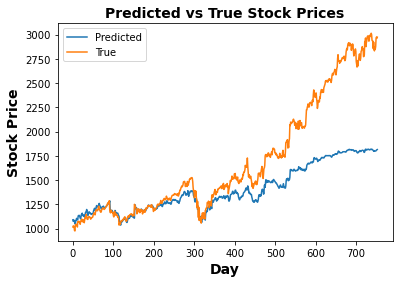

In [12]:
x_day = range(len(predicted))
plt.plot(x_day, pred_unscaled, label='Predicted')
plt.plot(x_day, true_unscaled, label='True')

plt.title('Predicted vs True Stock Prices',fontsize=14, fontweight='bold')
plt.xlabel('Day', fontsize=14, fontweight='bold')
plt.ylabel('Stock Price',fontsize=14, fontweight='bold')
plt.legend(loc='best')

# Show plot
plt.show()

## RMSE Values

In [13]:
# Get the RMSE value for multiple forecast steps
for fore_step in [10,20,30,40,50,60,753]:
    rmse = mean_squared_error(true_unscaled[:fore_step], pred_unscaled[:fore_step], squared=False)
    print("RMSE value for " + str(fore_step) + " forecast steps is: " + str(rmse))

RMSE value for 10 forecast steps is: 64.430664
RMSE value for 20 forecast steps is: 60.915787
RMSE value for 30 forecast steps is: 60.31953
RMSE value for 40 forecast steps is: 58.281303
RMSE value for 50 forecast steps is: 55.77256
RMSE value for 60 forecast steps is: 53.572605
RMSE value for 753 forecast steps is: 471.07892
